In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys 
from sklearn.model_selection import train_test_split

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 def convert_traits_to_boolean(df):
        trait_columns = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']
        d = {'y': 1, 'n': 0}

        for trait in trait_columns:
            df[trait] = df[trait].map(d)

        return df

In [3]:
# Load the dataset from a CSV file
df = pd.read_csv('mypersonality_final.csv', encoding="ISO-8859-1")
df.rename(columns = {'STATUS':'TWEET'}, inplace = True)
df = convert_traits_to_boolean(df)
        
text = df['TWEET']

# Split the dataset into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
train_df = train_df[['TWEET', 'cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU',]]

In [5]:
train_df.head()

,TWEET,cOPN,cCON,cEXT,cAGR,cNEU
5309,1 1//2 pages done...this thing needs to be 10!...,1,1,1,1,0
1406,had a 5 hour nap and is now procrastinating in...,1,0,0,0,1
682,needs everyone's BBM info.,1,0,0,0,0
7837,Congrats to *PROPNAME* on his wedding today an...,0,1,0,1,0
9751,Lord willing and with his blessing. I claim in...,1,0,0,0,1


In [6]:
target_list = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']

In [7]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 1e-05

In [8]:
from transformers import BertTokenizer, BertModel

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [10]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['TWEET']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [11]:
train_size = 0.8
train_df = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = test_df.sample(frac=train_size, random_state=200).reset_index(drop=True)

In [12]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [13]:

train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [14]:
device = torch.device("cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

In [15]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [16]:

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 5)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [17]:

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [18]:

val_targets=[]
val_outputs=[]

train_loss_data = []
valid_loss_data = []
train_loss_batch_data = []
valid_loss_batch_data = []

In [19]:

def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
   
 
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        valid_loss = 0

        model.train()
        print('############# Epoch {}: Training Start   #############'.format(epoch))
        for batch_idx, data in enumerate(training_loader):
            #print('yyy epoch', batch_idx)
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            #if batch_idx%5000==0:
             #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            #print('after loss data in training', loss.item(), train_loss)

        print('############# Epoch {}: Training End     #############'.format(epoch))

        print('############# Epoch {}: Validation Start   #############'.format(epoch))
            ######################    
            # validate the model #
            ######################

        model.eval()

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                train_loss = train_loss/len(training_loader)
                valid_loss = valid_loss/len(validation_loader)
                train_loss_batch_data.append(train_loss)
                valid_loss_batch_data.append(valid_loss)

        print('############# Epoch {}: Validation End     #############'.format(epoch))
              # calculate average losses
              #print('before cal avg train loss', train_loss)
        train_loss = sum(train_loss_batch_data)/len(train_loss_batch_data)
        valid_loss = sum(valid_loss_batch_data)/len(valid_loss_batch_data)
              # print training/validation statistics 
        print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
                    epoch, 
                    train_loss,
                    valid_loss
                    ))
        train_loss_data.append(train_loss)
        valid_loss_data.append(valid_loss)

              # create checkpoint variable and add important data
        checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
              }

                # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

              ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                    # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = valid_loss

        print('############# Epoch {}  Done   #############\n'.format(epoch))

    return model

In [20]:
print(train_loss_data)
print(valid_loss_data)

[]
[]


In [21]:
ckpt_path = "./bert_checkpoints/model.pt"
best_model_path = "./bert_checkpoints/best_model.pt"

In [22]:
# x = torch.tensor([0, 1, 2, 3, 4])
# torch.save(x, ckpt_path)

In [23]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000067 	Average Validation Loss: 0.001201
Validation loss decreased (inf --> 0.001201).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000067 	Average Validation Loss: 0.001196
Validation loss decreased (0.001201 --> 0.001196).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [24]:
import tweepy
import configparser
import pandas as pd
import re

def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    tweet = re.sub('https[^\s]+','',tweet)
    return tweet

def fetch_tweets(username):
    # read configs
    config = configparser.ConfigParser()
    config.read('config.ini')

    api_key = config['twitter']['api_key']
    api_key_secret = config['twitter']['api_key_secret']

    access_token = config['twitter']['access_token']
    access_token_secret = config['twitter']['access_token_secret']
    bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJCXiAEAAAAAlMOQc2O%2BbZib8Uw2sld4MLomM0E%3D4ePyxuoasHqc5YPP4NKRz6YwfYCbVVepKa1bh4pG3ljJiN4daS'
    #Put your Bearer Token in the parenthesis below
    client = tweepy.Client(bearer_token)
    
    query = 'from:'+ username + ' -is:retweet lang:en'
    tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                                  tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1000)


    columns = ['TWEET']
    data = []

    for tweet in tweets:
        data.append(tweet.text)
    
    

    df_pred = pd.DataFrame(data, columns = columns)
    df_pred = df_pred.replace("\s+", " ", regex=True).apply(lambda x: x.str.strip())

    print(df_pred['TWEET'])
    print('\n\n\n')
    df_pred['TWEET'] = df_pred['TWEET'].apply(remove_usernames_links)
    print(df_pred['TWEET'])
    for i in range(0, len(df_pred['TWEET'])):
        df_pred['TWEET'][i] = ' '.join(df_pred)
    

    return df_pred

In [25]:
import numpy as np
import matplotlib.pyplot as plt
 

def bar_plot(y_pred, title=""):
    # creating the dataset
    data = {'Openness': y_pred[0][0], 'Conscientiousness': y_pred[0][1], 'Aggreableness': y_pred[0][2], 'Extraversion': y_pred[0][3], 'Neuroticism': y_pred[0][4]}
    traits = list(data.keys())
    values = list(data.values())

    x = np.arange(len(traits)) # the label locations
    width = 0.35 # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_ylabel('Percentage')
    ax.set_xlabel('Traits')
    ax.set_title("Personality Prediction for @" + title)
    ax.set_xticks(x)
    ax.set_xticklabels(traits)
    ax.set_ylim([0 ,100])

    pps = ax.bar(x, values, width, label='traits', color='maroon')
    for p in pps:
       height = p.get_height()
       ax.annotate('{0:.5g}%'.format(height),
          xy=(p.get_x() + p.get_width() / 2, height),
          xytext=(0, 5), # 3 points vertical offset
          textcoords="offset points",
          ha='center', va='bottom')

    plt.show()
    
def multi_bar_plot(y_pred1, y_pred2, title1, title2):
    data1 = {'Openness': y_pred1[0][0], 'Conscientiousness': y_pred1[0][1], 'Aggreableness': y_pred1[0][2], 'Extraversion': y_pred1[0][3], 'Neuroticism': y_pred1[0][4]}
    data2 = {'Openness': y_pred2[0][0], 'Conscientiousness': y_pred2[0][1], 'Aggreableness': y_pred2[0][2], 'Extraversion': y_pred2[0][3], 'Neuroticism': y_pred2[0][4]}

    
    traits = list(data1.keys())
    values = list(data1.values()).copy()
    
    values2 = list(data2.values()).copy()

    x = np.arange(len(traits))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.bar(x - width/2, values, width, label=title1, color='royalblue')
    rects2 = ax.bar(x + width/2, values2, width, label=title2, color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Traits')
    ax.set_title("Personality Comparision of @"+title1+" and @"+title2)
    ax.set_xticks(x, traits)
    ax.set_ylim([0, 100])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
 
# traits = ["Openness", "Conscientiousness", "Agreeableness", "Extraversion", "Neuroticism"]

# data = {'Openness': y_pred['pred_prob_cOPN'], 'Conscientiousness': y_pred['pred_prob_cCON'], 'Aggreableness': y_pred['pred_prob_cAGR'], 'Extraversion': y_pred['pred_prob_cEXT'], 'Neuroticism': y_pred['pred_prob_cNEU']}
# actual = list(data.keys())
# expected = list(data.values())
def radial_plot(y_pred, title=""):
    data = {'Openness': y_pred[0][0]*100, 'Conscientiousness': y_pred[0][1]*100, 'Aggreableness': y_pred[0][2]*100, 'Extraversion': y_pred[0][3]*100, 'Neuroticism': y_pred[0][4]*100}
    traits = list(data.keys())
    values = list(data.values()).copy()
    values.append(values[0])


    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(8, 4))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2*np.pi, len(values), endpoint=True)

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(traits))), (traits))

    # Plot actual sales graph
    # plt.plot(theta, actual)

    # Plot expected sales graph
    plt.plot(theta, values, label = title)
    plt.fill(theta, values, 'b', alpha=0.1)
    plt.ylim(0, 100)

    # Add legend and title for the plot
    plt.legend(loc=1)
    plt.title("Personality Prediction for @" + title)

    # Dsiplay the plot on the screen
    plt.show()
    
def radial_plot_comparision(y_pred1, y_pred2, title1, title2):
 
    data1 = {'Openness': y_pred1[0][0], 'Conscientiousness': y_pred1[0][1], 'Aggreableness': y_pred1[0][2], 'Extraversion': y_pred1[0][3], 'Neuroticism': y_pred1[0][4]}
    data2 = {'Openness': y_pred2[0][0], 'Conscientiousness': y_pred2[0][1], 'Aggreableness': y_pred2[0][2], 'Extraversion': y_pred2[0][3], 'Neuroticism': y_pred2[0][4]}

    
    traits = list(data1.keys())
    values = list(data1.values()).copy()
    values.append(values[0])
    
    values2 = list(data2.values()).copy()
    values2.append(values2[0])

    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(8, 4))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2 * np.pi, len(values))

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(traits))), (traits))

    # Plot actual sales graph
    plt.plot(theta, values, label=title1)
    plt.fill(theta, values, 'blue', alpha=0.1)

    # Plot expected sales graph
    plt.plot(theta, values2, label=title2)
    plt.fill(theta, values2, 'orange', alpha=0.1)

    # Add legend and title for the plot
    plt.legend(loc=1)
    plt.title("Personality Comparision of @"+title1+" and @"+title2)

    plt.ylim(0 ,100)
    # Dsiplay the plot on the screen
    plt.show()

In [27]:
username = str(input('enter username: '))

enter username: elonmusk


0                           @PeterDiamandis We should be
1                    @shellenberger You’re exactly right
2      @bchesky This kind of interaction with users i...
3       NASA Spaces about space! https://t.co/FDqxxS52oT
4                                     @zerohedge Excel 🙌
                             ...                        
150     @billmaher @HBO @RealTimers Thanks for having me
151                     Falcon Heavy is green for launch
152                            @CommunityNotes Good idea
153    About to do Falcon Heavy risk review. I love t...
154                           On @billmaher show tonight
Name: TWEET, Length: 155, dtype: object




0                                           We should be
1                                   You’re exactly right
2       This kind of interaction with users is awesom...
3                              NASA Spaces about space! 
4                                                Excel 🙌
                             ...            

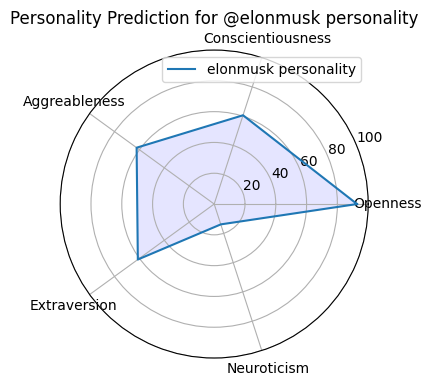


************************************

cOPN


In [28]:
# testing
df_pred = fetch_tweets(username)
example = df_pred["TWEET"][0]
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
trained_model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = trained_model(input_ids, attention_mask, token_type_ids)
#     print(output)
#     print("\n************************************\n")
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(final_output)
    radial_plot(final_output, "elonmusk personality")
    print("\n************************************\n")
    print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])

In [29]:
train_loss_data

[6.731705207896349e-05,
 6.67116811242686e-05,
 6.591797473033167e-05,
 6.46299528797885e-05,
 6.28566099365292e-05,
 6.0547964979488373e-05,
 5.793926919542281e-05,
 5.525414605357551e-05]

In [30]:
valid_loss_data

[0.0012010275104845857,
 0.001196063537705968,
 0.0011906740364758452,
 0.0011910040983358658,
 0.0011948288471501272,
 0.0012108181172244996,
 0.0012333346577195843,
 0.001263277217275839]

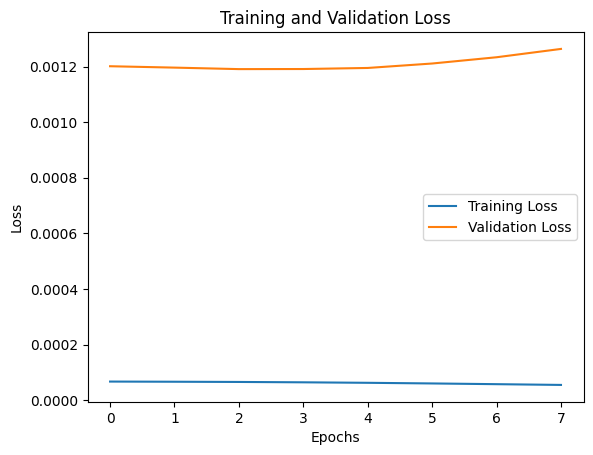

In [31]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange
 
# Retrieve each dictionary's values
train_values = train_loss_data
val_values = valid_loss_data
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(8)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 8, 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [32]:
sum(train_loss_data)/len(train_loss_data)

6.264683137229602e-05

In [33]:
sum(valid_loss_data)/len(valid_loss_data)

0.0012101285027965392